In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import wavio
import librosa
import librosa.display

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import time
from random import shuffle

# Data Visualizatoin
import matplotlib.pyplot as plt
# %matplotlib inline

#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
 #       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_dir = '../input/respiratory_sound_database'

demogr_fname = '../input/respiratory-sound-database/demographic_info.txt'
demogrCol_strLst = ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)']
demogr_df = pd.read_csv(
    demogr_fname, 
    names = demogrCol_strLst,
    delimiter = ' ',
)

demogr_fname = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosisCol_strLst = ['Patient number', 'Diagnosis']
diagnosis_df = pd.read_csv(
    demogr_fname,
    names = diagnosisCol_strLst,
)

data_dname = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
records_idLst = [s.split('.')[0] for s in os.listdir(path = data_dname) if '.txt' in s]

print("# Of recordings: %d"%(len(records_idLst)))

# Of recordings: 920


In [3]:
def loadData(record_id, dry = False):
    
    data_fname = record_id + '.wav'
    annotation_fname = record_id + '.txt'
    
    if not dry:
        wave_data = wavio.read(data_dname+'/'+data_fname)
        waveform_np = wave_data.data.astype(float).flatten()
        waveWidth_int= wave_data.sampwidth

        # Get the info of the wavefile
        fs = wave_data.rate # Sampling frequency
        N = waveform_np.shape[0]
        
    else:
        waveform_np = None
        fs = float('nan')
        N = float('nan')
    Ts = 1.0 / fs;
    AT = Ts * N    

    tokens_strLst = record_id.split('_') + [fs, N, AT, Ts]
    
    infoLabels_strLst = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment', 'fs', 'N', 'AT', 'Ts']
    recordInfo_dict = dict(zip(infoLabels_strLst,tokens_strLst))
    
    dataCols_strLst = ['Start', 'End', 'Crackles', 'Wheezes']
    recAnnotations_df = pd.read_csv(
        os.path.join(data_dname, annotation_fname), 
        names = dataCols_strLst,
        delimiter= '\t'
    )
    
    return (waveform_np, recordInfo_dict, recAnnotations_df)

(waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0], 0)
_, recordInfo_dict, recAnnotations_df = loadData(records_idLst[0], 1)

In [4]:
# Class to time the execution blocks
class Timer():
    # Static variable for verbosity
    quiet = False
    
    # Init the class
    def __init__(self, str): 
        # print('init method called') 
        self.str = str
        
    # Enter the context
    def __enter__(self):
        # print('enter method called') 
        self.tick = time.time()
        return self
    
    # Leave the context
    def __exit__(self, exc_type, exc_value, exc_traceback): 
        if not Timer.quiet:
            print("%s: \t%.3f s"%(self.str, time.time() - self.tick))

<AxesSubplot:>

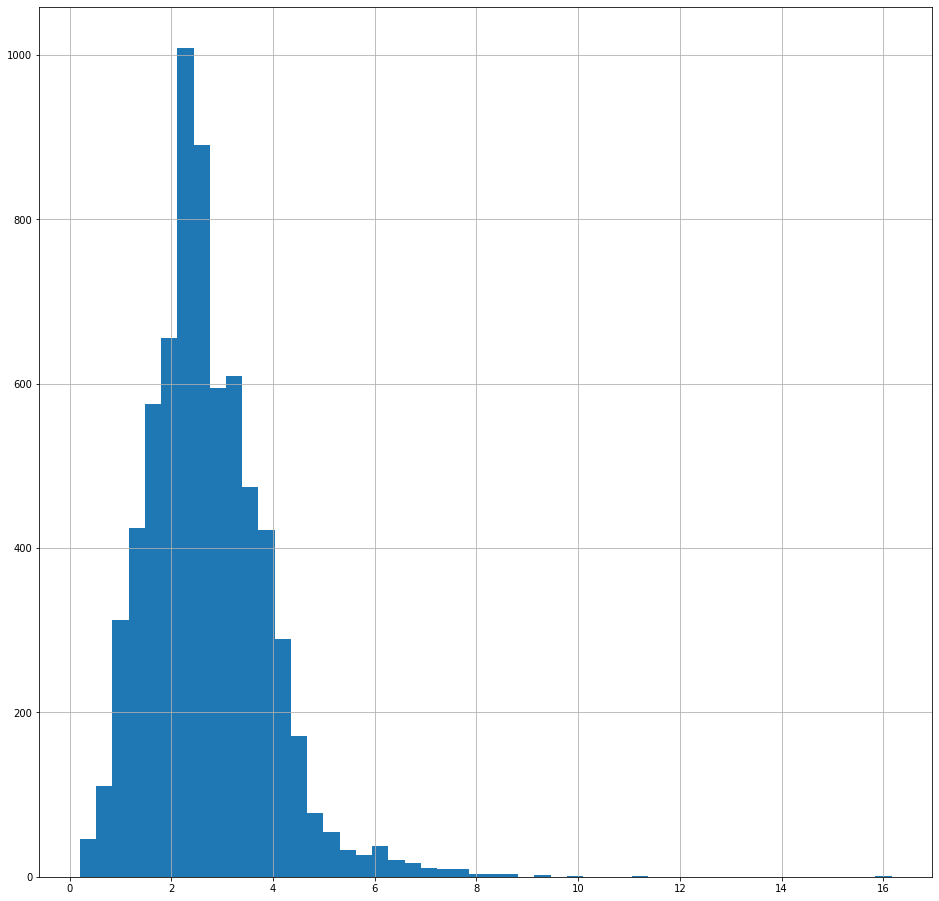

In [5]:
# Distribution of respiratory cycle lengths

respDuration_ser = pd.Series([],dtype='float64')
for record_id in records_idLst:
    _, recordInfo_dict, recAnnotations_df = loadData(record_id, dry = True)
    respDuration_ser = respDuration_ser.append(recAnnotations_df['End'] - recAnnotations_df['Start'])

plt.figure(figsize=(16,16))
respDuration_ser.hist(bins=50)

In [6]:
# Feature extraction

# Parameters
frameLength_int = 2**13
frameHop_int = 2**11

# Derivative values
frameOvelap_int = frameLength_int - frameHop_int

def extractFeatures(waveform_np, recordInfo_dict, dry=False):
    
    if dry:
        # Extract the spectrum from the waveform
        spectrum_np = librosa.core.stft(
           waveform_np, 
           n_fft=frameLength_int, 
           hop_length=frameHop_int, 
           win_length=frameLength_int, 
        )
        spectrumMag_np = np.abs(spectrum_np)
        spectrumN_int = spectrumMag_np.shape[1]
        spectrumTime_np = np.linspace(0,recordInfo_dict['AT'],spectrumN_int)
    else:
        # Chroma Frequencies
        chroma_np = librosa.feature.chroma_stft(
            waveform_np, 
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Spectral Centroid
        spectralCentroid_np = librosa.feature.spectral_centroid(
            waveform_np,
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Spectral Bandwidth
        spectralBandwidth_np = librosa.feature.spectral_bandwidth(
            waveform_np, 
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Spectral Roll-off
        spectralRolloff_np = librosa.feature.spectral_rolloff(
            waveform_np,
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

        # Zero Crossing Rate
        spectralZeroCrossing_zp = librosa.feature.zero_crossing_rate(
            waveform_np,
            hop_length=frameHop_int, 
            frame_length=frameLength_int, 
        )

        # Mel Cepstral Coeffs (MFCC)
        mfcc_np = librosa.feature.mfcc(
            waveform_np,
            sr=recordInfo_dict['fs'],
            n_fft=frameLength_int, 
            hop_length=frameHop_int, 
            win_length=frameLength_int, 
        )

    features_np = np.concatenate((
#        spectrumMag_np,
        spectralCentroid_np,
        spectralBandwidth_np,
        spectralRolloff_np,
        spectralZeroCrossing_zp,
#        chroma_np,
        mfcc_np,
    )).T
    
    
    
    scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    features_np = scaler.fit_transform(features_np)
        
    return features_np


(waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0])
features_np = extractFeatures(waveform_np, recordInfo_dict)

print(features_np.shape)
print(features_np.min(axis=0))
print(features_np.mean(axis=0))
print(features_np.max(axis=0))
print(features_np.std(axis=0))

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


(431, 24)
[-1.06772143 -1.45044458 -0.47546912 -1.13335331 -2.10692955 -2.23206682
 -2.53492939 -2.16368881 -1.67786028 -1.62685532 -2.01731435 -3.90149276
 -2.73476371 -2.71929057 -2.96249927 -3.06898585 -3.35116994 -2.64281456
 -3.30285535 -2.90615546 -2.82706826 -3.39124417 -3.3465905  -2.80285346]
[ 2.59653088e-16 -1.85466491e-16 -2.88503431e-17 -1.64859103e-16
  9.72668710e-16 -1.81345014e-16  7.50108921e-16  7.00651190e-17
  1.40130238e-16 -3.04989341e-16  4.53362534e-17 -3.91540371e-17
  4.03904803e-16  2.06073879e-16 -2.80260476e-16  2.55531610e-16
 -2.80260476e-16 -4.28633669e-16  2.22559790e-16 -4.53362534e-17
  2.14316834e-16  3.37961162e-16  1.48373193e-16  2.47288655e-17]
[3.26827865 2.53464655 4.92855358 3.64412338 2.29416335 2.22411074
 1.75637386 2.43104037 2.55730563 2.77866358 2.75162526 3.17926319
 3.21848877 3.14833279 2.65320143 2.5344358  3.03807859 2.90126692
 3.42964405 3.80329412 3.23907225 2.71566637 2.92343119 2.91668797]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [7]:
spectrum_np = librosa.core.stft(
   waveform_np, 
   n_fft=frameLength_int, 
   hop_length=frameHop_int, 
   win_length=frameLength_int, 
)
spectrumMagLog_np = np.log(np.abs(spectrum_np))
spectrumN_int = spectrumMagLog_np.shape[1]
spectrumTime_np = np.linspace(0,recordInfo_dict['AT'],spectrumN_int)

In [8]:
# Convert the annotations to a usable Y vector
# TODO: Perhaps we can use a complex periodic signal i.e. 2 output vectors

def annotations2Y(recAnnotations_df, recordInfo_dict):

    # Variables
    t = spectrumTime_np
    Y = np.zeros(t.shape[0])
    lag_f = 0
    
    for row in recAnnotations_df.itertuples():
        start_f = row.Start
        stop_f = row.End
        duration_f = stop_f - start_f
        mask_b = np.logical_and(t >= start_f, t < stop_f)
        x = 0.5 - np.cos(2*np.pi*(t-stop_f)/duration_f)/2
        
        Y[mask_b] = x[mask_b]
        
    return t,Y

t_np, Y_np = annotations2Y(recAnnotations_df, recordInfo_dict)

print(spectrumMagLog_np.shape)


(4097, 431)


In [9]:
def generateDataset(records_idLst):
    
    records_cnt = len(records_idLst)
    
    # This function takes time so lets do some reporting
    print("Generating a dataset of %d records"%(records_cnt))
    
    datasetX_np = None
    datasetY_np = None
    for index_int, record_id in enumerate(records_idLst):
        
        # Load the file
        (waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0])

        # Extract the features
        features_np = extractFeatures(waveform_np, recordInfo_dict, )

        # Extract the target
        t_np, Y_np = annotations2Y(recAnnotations_df, recordInfo_dict)

        if datasetX_np is None:
            datasetX_np = features_np
            datasetY_np = Y_np
        else:
            datasetX_np = np.append(datasetX_np, features_np, axis=0)
            datasetY_np = np.append(datasetY_np, Y_np)
        print("Loading: %5.2f%%\t%s"%(100.0 * (index_int + 1) / records_cnt, record_id), end="\r")
        
    print("")
    print(datasetX_np.shape)
    print(datasetY_np.shape)
    return datasetX_np, datasetY_np

In [10]:
# Parameters
testN_cnt = 10

# Randomize the dataset order
shuffle(records_idLst)
# Split the training and test datasets
trainRecords_idLst = records_idLst[testN_cnt:]
testRecords_idLst = records_idLst[:testN_cnt]

In [11]:
def evaluateModel(model):
    
    trainR2_f = model.score(trainX_np, trainY_np)
    testR2_f = model.score(testX_np, testY_np)
    print("Train R2: %8.5f\t Test R2: %8.5f\t (%5.2f)"%(trainR2_f,testR2_f,testR2_f/trainR2_f))

    trainResult_np = model.predict(trainX_np)
    testResult_np = model.predict(testX_np)
    visualResult_np = model.predict(visualX_np)

    trainMAE_f = metrics.mean_absolute_error(trainY_np, trainResult_np)
    testMAE_f = metrics.mean_absolute_error(testY_np, testResult_np)
    print("Train MAE: %8.5f\t Test MAE: %8.5f\t (%5.2f)"%(trainMAE_f,testMAE_f,testMAE_f/trainMAE_f))

    # Visualize the test performance
    visualX_np, visualY_np

    plt.figure(figsize=(24,10))
    
    plt.subplot(211)
    plt.plot(trainY_np[:visualN_cnt],'g')
    plt.plot(trainResult_np[:visualN_cnt],'b.')
    plt.title('Training Set fit')
    
    plt.subplot(212)
    plt.plot(visualY_np,'g')
    plt.plot(visualResult_np,'b.')
    plt.title('Test Set fit')

In [12]:
# Create the training dataset

with Timer("Training set generation:"):
    trainX_np, trainY_np = generateDataset(trainRecords_idLst)
print("Training dataset consists of %d records"%(len(trainRecords_idLst)))

Generating a dataset of 910 records
Loading: 100.00%	158_1p3_Tc_mc_AKGC417L
(392210, 24)
(392210,)
Training set generation:: 	725.979 s
Training dataset consists of 910 records


In [13]:
# Create the test set

testX_np, testY_np = generateDataset(testRecords_idLst)

print("Test dataset consists of %d records"%(len(testRecords_idLst)))

Generating a dataset of 10 records


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Loading: 100.00%	116_1b2_Tc_sc_Meditron
(4310, 24)
(4310,)
Test dataset consists of 10 records


Generating a dataset of 1 records


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Loading: 100.00%	107_2b5_Lr_mc_AKGC417L
(431, 24)
(431,)
N: 882000
AT: 20.0


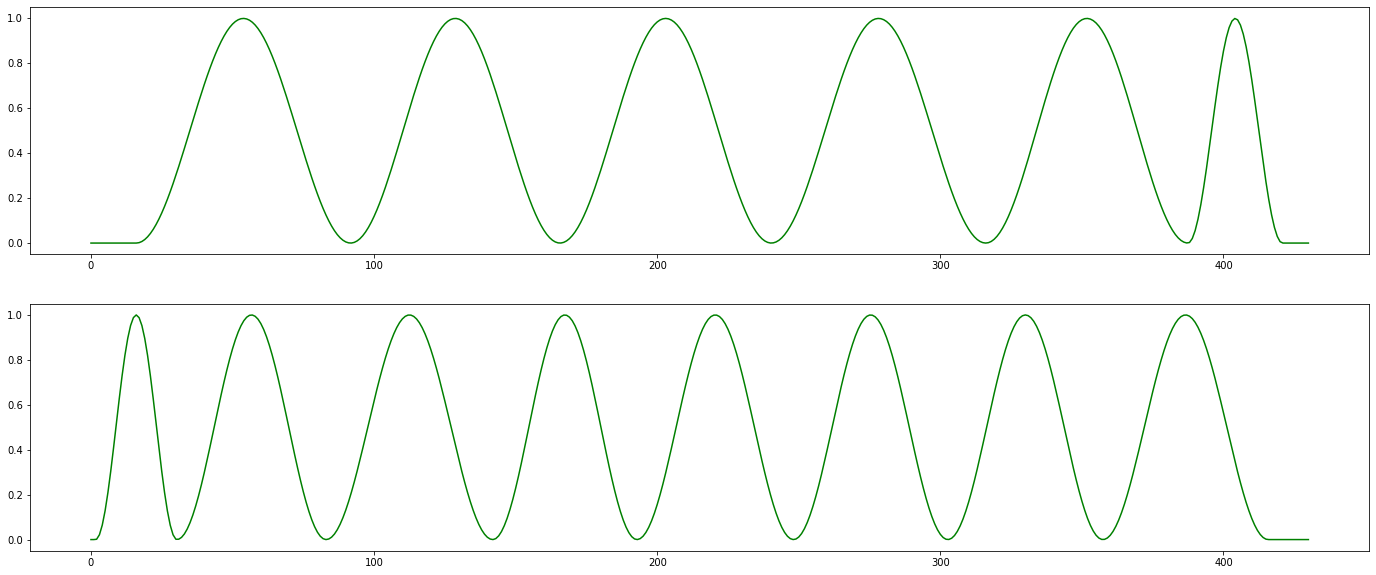

In [14]:
# Pick a record from the validation set to do the visualization

records_idLst = [testRecords_idLst[0]]
#records_idLst = [trainRecords_idLst[0]]

visualX_np, visualY_np = generateDataset(records_idLst)
visualN_cnt = visualX_np.shape[0]

(waveform_np, recordInfo_dict, recAnnotations_df) = loadData(records_idLst[0], False)

print("N:",recordInfo_dict['N'])
print("AT:",recordInfo_dict['AT'])

plt.figure(figsize=(24,10))
plt.subplot(211)
plt.plot(trainY_np[:visualN_cnt],'g')
plt.subplot(212)
plt.plot(visualY_np,'g')

Training Linear Regression:: 	0.318 s
Train R2:  0.22261	 Test R2: -0.43088	 (-1.94)
Train MAE:  0.27491	 Test MAE:  0.36566	 ( 1.33)


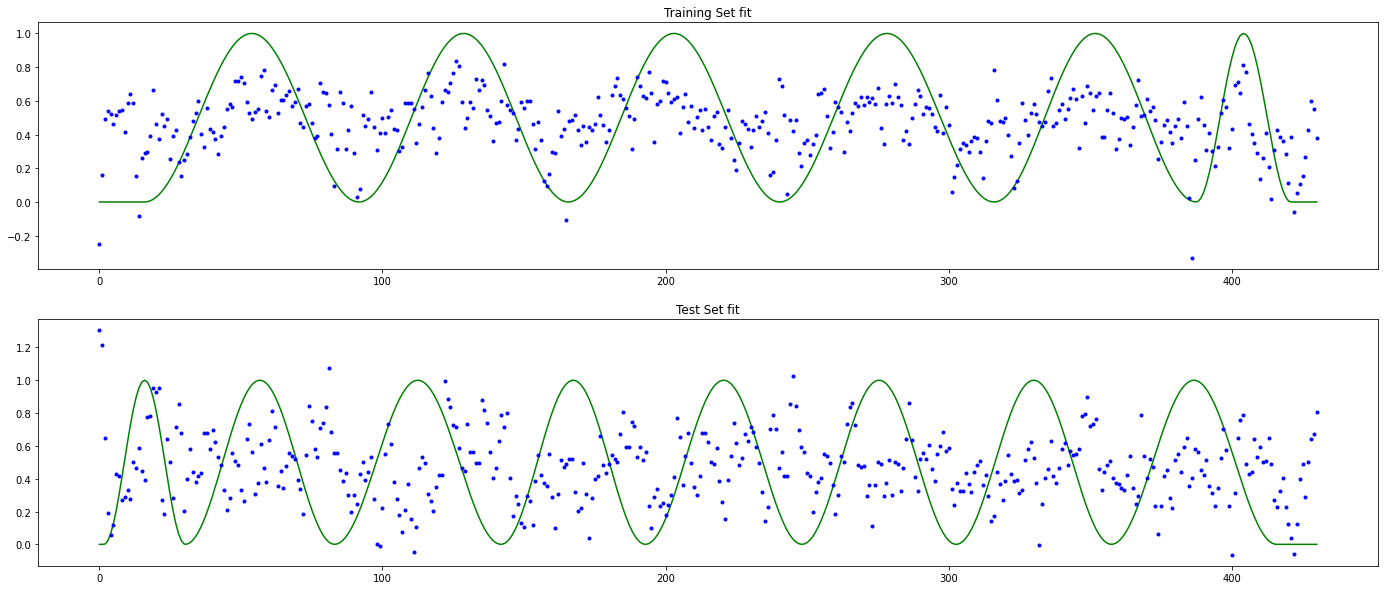

In [15]:
# Try Linear Regression

model = LinearRegression()

with Timer("Training Linear Regression:"):
    model.fit(trainX_np,trainY_np)

evaluateModel(model)

Training Decision Tree Regression:: 	3.228 s
Train R2:  1.00000	 Test R2: -1.12340	 (-1.12)
Train MAE:  0.00000	 Test MAE:  0.41185	 (70786953492447.80)


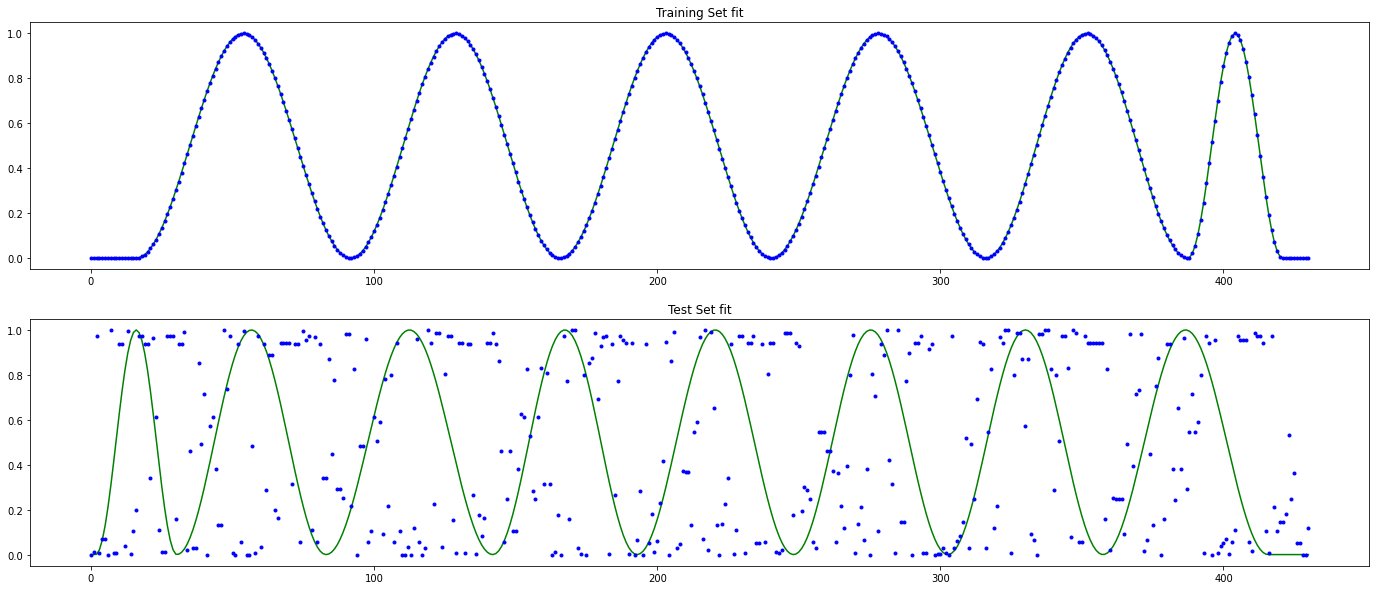

In [16]:
# Try Decision Tree Regression

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(
    criterion = 'mse',
#    max_depth = 15,
)

with Timer("Training Decision Tree Regression:"):
    model.fit(trainX_np,trainY_np)


evaluateModel(model)

Training Random Forest Regression:: 	68.282 s
Train R2:  1.00000	 Test R2: -0.95914	 (-0.96)
Train MAE:  0.00000	 Test MAE:  0.40021	 (159196529599822.56)


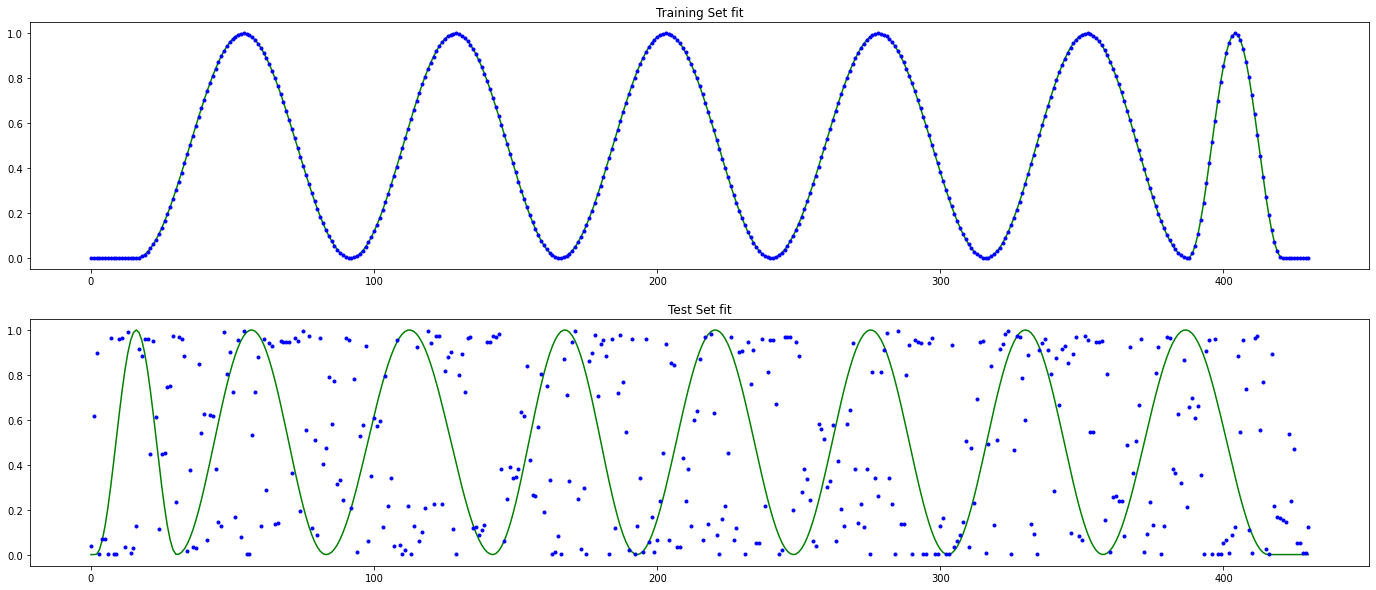

In [17]:
# Try Random Forest Regression

from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor(
    n_estimators = 30,
#    max_depth = 10,
#    min_samples_split = 100,   
#    random_state = 0,
) 

with Timer("Training Random Forest Regression:"):
    model.fit(trainX_np,trainY_np)

evaluateModel(model)